In [ ]:
from skimage.transform import resize
from skimage.io import imread, imsave, imshow
from skimage.color import rgb2gray, rgb2lab, lab2rgb, gray2rgb
import skimage
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
'''
Global Paths
'''
IMAGE_ROOT = 'img'
ORIGINAL_IMAGES = IMAGE_ROOT + '/colored_inputs/'
RESIZED_IMAGES = IMAGE_ROOT + '/resized_inputs/'
PREDICTED_IMAGES = IMAGE_ROOT + '/predicted/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/

Mounted at /content/drive/
/content/drive/My Drive


In [ ]:
'''
Split data into train, test, validate sets
'''
class DataLoader:
    def __init__(self, split=0.9):        
        data = []
        image_paths = os.listdir(RESIZED_IMAGES)
        
        for path in image_paths:
            try:
                img = imread(RESIZED_IMAGES+path)
                data.append(img)
            except:
                pass
        data = np.array(data, dtype=float)
        self.train = data[int((1-split)*len(data)):]
        self.validate = data[:int((1-split)*len(data))]
    
    def resize(self, img): # resize images to 256 x 256 square
        if img.shape[0] < 256 and img.shape[1] < 256:
            return None
        if len(img.shape) != 3: # if img is already gray
            return None
        
        if img.shape[0] != img.shape[1]:
            if img.shape[0] % 2 == 1:
                img = img[1:,:,:]
            if img.shape[1] % 2 == 1:
                img = img[:,1:,:]
            if img.shape[0] > img.shape[1]:
                img = img[abs(int((img.shape[0] - img.shape[1])/2)):abs(int((img.shape[0] - img.shape[1])/2)) + img.shape[1], :, :]
            elif img.shape[0] < img.shape[1]:
                img = img[:, abs(int((img.shape[0] - img.shape[1])/2)):abs(int((img.shape[0] - img.shape[1])/2)) + img.shape[0], :]
        
        return resize(img, (256, 256, 3))            

In [ ]:
data_loader = DataLoader()

In [ ]:
print(data_loader.train.shape)
print(data_loader.validate.shape)

(3871, 256, 256, 3)
(430, 256, 256, 3)


In [ ]:
# Model Imports
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def get_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(256,256,1)))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
    model.add(UpSampling2D((2, 2)))
    
    opt = Adam(learning_rate=0.0001)
    # model.compile(loss='categorical_crossentropy', optimizer=opt)
    model.compile(optimizer=opt, loss='mse')
    # print(model.summary())
    return model
    

In [ ]:
def get_next_batch(generator, train, batch_size):
    for batch in generator.flow(train, batch_size=batch_size):
        lab = rgb2lab(batch * 1.0/255)
        l_batch = lab[:,:,:,0]
        ab_batch = lab[:,:,:,1:] / 128
        print(ab_batch.shape, ab_batch[:,:,:,0].min(), ab_batch[:,:,:,0].max())
        yield (l_batch.reshape(l_batch.shape[0], l_batch.shape[1], l_batch.shape[2], 1), ab_batch)

def process_validation_data(validate):
    lab = rgb2lab(validate * 1.0/255)
    l = lab[:,:,:,0]
    ab = lab[:,:,:,1:] / 128
    return (l.reshape(l.shape[0], l.shape[1], l.shape[2], 1), ab)

In [ ]:
batch_size = 8
epochs = 50
steps_per_epoch = 1000

In [ ]:
def train_model():
    generator = ImageDataGenerator(zca_epsilon=0.005, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, dtype=float)
    next_batch = get_next_batch(generator, data_loader.train[:1000, :, :, :], batch_size)
    
    model = get_model()
    model.fit_generator(next_batch, epochs=epochs, steps_per_epoch=steps_per_epoch)
    model.save_weights("./model_50epochs_1000steps_8batch.h5")
    return model

In [ ]:
model = train_model()

lab range -51.84885546499951 100.0
l range 0.0 100.0
ab range -51.84885546499951 84.62336148068587


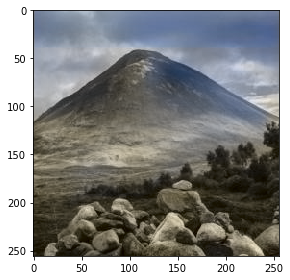

In [ ]:
model = get_model()
model.load_weights("model_50epochs_1000steps_8batch.h5")

test_l, test_ab = process_validation_data(data_loader.validate[:10, :, :, :])

val_images = np.array(test_l, dtype=float)

img = np.zeros((256,256,3))
predicted = model.predict(val_images) * 128 

for i in range(len(predicted)):
    img = np.zeros((256,256,3))
    img[:,:,0] = val_images[i][:,:,0]
    img[:,:,1:] = predicted[i]
    imsave(PREDICTED_IMAGES+"/"+str(i)+'.jpg', lab2rgb(img))
    